File: jupyter/notebooks/tcdiags.vurk2014_msi.ipynb

Author: Henry R. Winterbottom

Date: 27 August 2023

Version: 0.0.1

License: LGPL v2.1

Topic: This notebook computes and plots tropical cyclone (TC) multi-scale intensity (MSI) attributes described by Vukicevic et al., [2014].

References:

    Vukicevic, T., E., Uhlhorn, P. Reasor, and B. Klotz, A novel multiscale intensity metric for evaluation of tropical cyclone intensity forecasts, J. Atmos. Sci., 71 (4), 1292-13-4, 2014.

In [1]:
from collections import OrderedDict

from tcdiags.tcdiags import TCDiags
import matplotlib.cm as colormaps
import matplotlib.pyplot as plt

import numpy
from ioapps import netcdf4_interface
from IPython.display import HTML, display
from tabulate import tabulate
from tools import parser_interface

### User Configuration

In [2]:
# YAML-formatted configuration file.
yaml = "/home/ufs_tcdiags/parm/tcdiags.demo.yaml"

# Define the TC MSI plotting attributes for the total wind and wave-number 0.
vmax_cint = 5.0
vmax_cmax = 30.0
vmax_cmin = 0.0
vmax_cmap = "jet"
vmax_levels = numpy.linspace(vmax_cmin, vmax_cmax, 255)

# Define the TC MSI plotting attributes for the wave-number 1 - wave-number N fields.
wn_cint = 1.0
wn_cmax = 5.0
wn_cmin = -5.0
wn_cmap = "seismic"
wn_levels = numpy.linspace(wn_cmin, wn_cmax, 255)

# Define the TC MSI attributes stored as netCDF global attributes; 
# this dictionary contains the global attribute name and the corresponding units.
tcmsi_attrs_dict = OrderedDict({"lat_deg":{"name": "Center Latitude", "units": "degrees"},
                                "lon_deg":{"name": "Center Longitude", "units": "degrees"},
                                "lat_rmw": {"name": "Radius of Maximum Wind Latitude", "units": "degrees"},
                                "lon_rmw": {"name": "Radius of Maximum Wind Longitude", "units": "degrees"},
                                "vmax": {"name": "Maximum 10-meter Wind Speed", "units": "mps"},
                                "rmw_azimuth": {"name": "Azimuth of Maximum 10-meter Wind Speed", "units": "degrees"},
                                "rmw_radius": {"name": "Radius of Maximum 10-meter Wind Speed", "units": "m"},
                                "wn0_msi": {"name": "Wavenumber-0 Maximum Wind Speed", "units": "mps"},
                                "wn1_msi": {"name": "Wavenumber-1 Maximum Wind Speed", "units": "mps"},
                                "wn0p1_msi": {"name": "Wavenumbers (0+1) Maximum Wind Speed", "units": "mps"},
                                "epsi_msi": {"name": "Residual Wavenumber Maximum Wind Speed", "units": "mps"},
                                }
                              )

### Compute the tropical cyclone multi-scale intensity attributes.

In [3]:
options_obj = parser_interface.object_define()
options_obj.yaml = yaml
options_obj.tcmsi = True
tcdiag_obj = TCDiags(options_obj=options_obj)
tcmsi = tcdiag_obj.run().tcmsi

2023-09-06 14:37:08 :: WARNING :: utils.schema_interface: Schema optional value derived has not been defined; setting to default value False.
2023-09-06 14:37:08 :: WARNING :: utils.schema_interface: Schema optional value method has not been defined; setting to default value None.
2023-09-06 14:37:08 :: WARNING :: utils.schema_interface: Schema optional value module has not been defined; setting to default value None.
2023-09-06 14:37:08 :: WARNING :: utils.schema_interface: Schema optional value scale_mult has not been defined; setting to default value 1.0.
2023-09-06 14:37:08 :: WARNING :: utils.schema_interface: Schema optional value scale_add has not been defined; setting to default value 0.0.
2023-09-06 14:37:08 :: INFO :: utils.schema_interface: 

+--------------+--------+------------+-----------------+---------------------------------------------+
|   Variable   |  Type  |  Optional  | Default Value   | Assigned Value                              |
+==============+========+=====

### Plot the tropical cyclone multi-scale intensity attributes.

TC 14L MSI Attributes,Value (Units)
Center Latitude,13.4 (degrees)
Center Longitude,-72 (degrees)
Radius of Maximum Wind Latitude,12.373095556722303 (degrees)
Radius of Maximum Wind Longitude,-72.30604517770875 (degrees)
Maximum 10-meter Wind Speed,22.09724998474121 (mps)
Azimuth of Maximum 10-meter Wind Speed,60.000000000000135 (degrees)
Radius of Maximum 10-meter Wind Speed,120000.0 (m)
Wavenumber-0 Maximum Wind Speed,18.144823659624375 (mps)
Wavenumber-1 Maximum Wind Speed,3.1016818996685966 (mps)
Wavenumbers (0+1) Maximum Wind Speed,19.831703222806482 (mps)


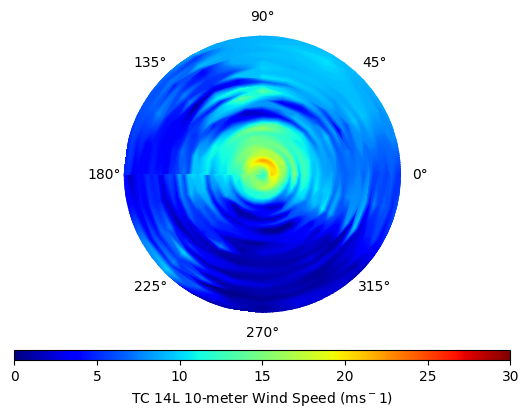

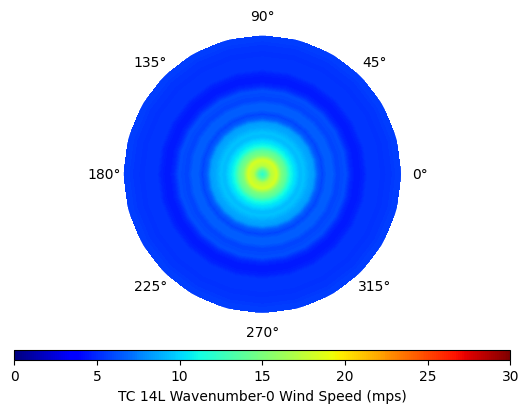

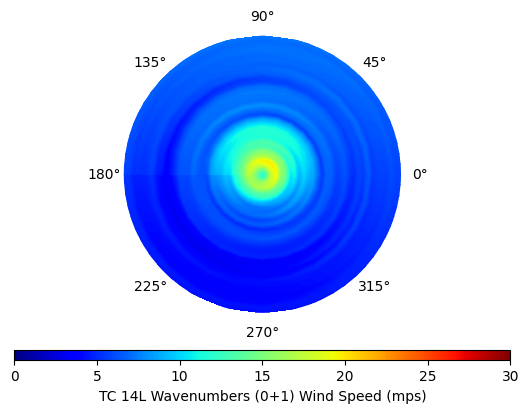

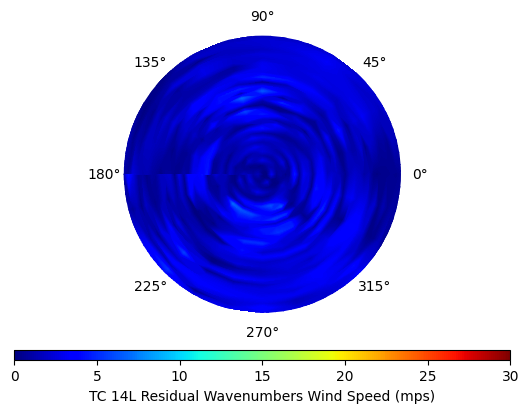

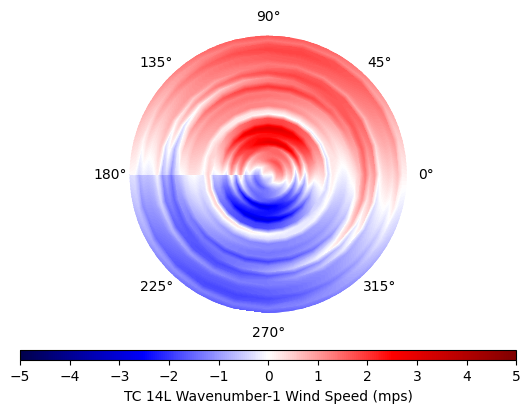

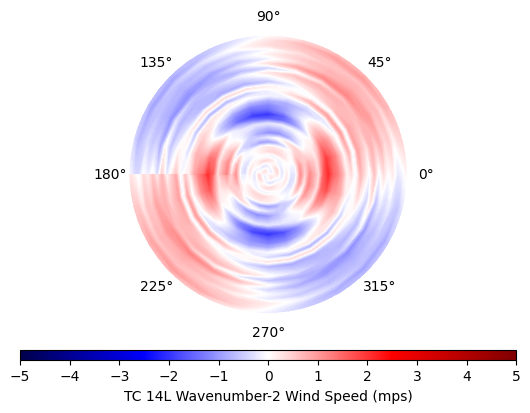

In [4]:
# Build a table containing the TC MSI attributes.
tcids = parser_interface.object_getattr(object_in=tcmsi, key="tcids")
for tcid in tcids:
    header = [f"TC {tcid} MSI Attributes", "Value (Units)"]
    tcobj = parser_interface.object_getattr(object_in=tcmsi, key=tcid)
    table = []
    for tcmsi_attr in tcmsi_attrs_dict:
        try:
            value = parser_interface.object_getattr(object_in=tcobj, key=tcmsi_attr)._magnitude
        except Exception:
            value = parser_interface.object_getattr(object_in=tcobj, key=tcmsi_attr)
        name = parser_interface.dict_key_value(dict_in=tcmsi_attrs_dict[tcmsi_attr],
                                               key="name", no_split=True)
        units = parser_interface.dict_key_value(dict_in=tcmsi_attrs_dict[tcmsi_attr],
                                                key="units", no_split=True)
        msg = [name, f"{value} ({units})"]
        table.append(msg)
    
    # Display the table.
    table = tabulate(table, header, tablefmt="html", numalign=("center", "center"),
                    colalign=("center","center")) 
    display(HTML(table))
   
    # Collect/define the grid attributes.
    azimuth = tcobj.wnds10m.azimuth
    radial = tcobj.wnds10m.radial/1000.0
    xticks = numpy.radians(numpy.arange(0., 360.0, 45.0))
    yticks = []

    # Plot the total wind field.
    (fig, ax) = plt.subplots(subplot_kw={'projection': 'polar'})
    total_wind = tcobj.wnds10m.varout
    plot = ax.contourf(azimuth, radial, total_wind, levels=vmax_levels, cmap=vmax_cmap)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.spines['polar'].set_color('none')
    ticks = numpy.arange(vmax_cmin, (vmax_cmax + 0.01), vmax_cint)
    plt.colorbar(plot, orientation="horizontal", ticks=ticks, pad=0.1,
                 aspect=50, label=f"TC {tcid} 10-meter Wind Speed (ms$^{-1}$)")
    plt.savefig(f"tcwnmsi.10m_wind.{tcid}.png", dpi=500, transparent=False, 
                bbox_inches="tight")
    plt.show()
    
    # Plot the wave-number 0 wind field.
    (fig, ax) = plt.subplots(subplot_kw={'projection': 'polar'})
    wn0 = tcobj.wndspec.wn0
    plot = ax.contourf(azimuth, radial, wn0, levels=vmax_levels, cmap=vmax_cmap)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.spines['polar'].set_color('none')
    ticks = numpy.arange(vmax_cmin, (vmax_cmax + 0.01), vmax_cint)
    plt.colorbar(plot, orientation="horizontal", ticks=ticks, pad=0.1,
                 aspect=50, label=f"TC {tcid} Wavenumber-0 Wind Speed (mps)")
    plt.savefig(f"tcwnmsi.wn0_wind.{tcid}.png", dpi=500, transparent=False, bbox_inches="tight")
    plt.show()

    # Plot the wave-number 0+1 wind field.
    (fig, ax) = plt.subplots(subplot_kw={'projection': 'polar'})
    wn0p1 = wn0 + tcobj.wndspec.wn1
    plot = ax.contourf(azimuth, radial, wn0p1, levels=vmax_levels, cmap=vmax_cmap)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.spines['polar'].set_color('none')
    ticks = numpy.arange(vmax_cmin, (vmax_cmax + 0.01), vmax_cint)
    plt.colorbar(plot, orientation="horizontal", ticks=ticks, pad=0.1,
                 aspect=50, label=f"TC {tcid} Wavenumbers (0+1) Wind Speed (mps)")
    plt.savefig(f"tcwnmsi.wn0p1_wind.{tcid}.png", dpi=500, transparent=False, bbox_inches="tight")
    plt.show()

    # Plot the residual components of the wind field.
    (fig, ax) = plt.subplots(subplot_kw={'projection': 'polar'})
    wnres = numpy.abs(total_wind - wn0p1._magnitude)
    plot = ax.contourf(azimuth, radial, wnres, levels=vmax_levels, cmap=vmax_cmap)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.spines['polar'].set_color('none')
    ticks = numpy.arange(vmax_cmin, (vmax_cmax + 0.01), vmax_cint)
    plt.colorbar(plot, orientation="horizontal", ticks=ticks, pad=0.1,
                 aspect=50, label=f"TC {tcid} Residual Wavenumbers Wind Speed (mps)")
    plt.savefig(f"tcwnmsi.wnres_wind.{tcid}.png", dpi=500, transparent=False, bbox_inches="tight")
    plt.show()    

    # Plot the wave number spectra for the wind field.
    for wn in range(1, tcobj.ncoeffs):
        (fig, ax) = plt.subplots(subplot_kw={'projection': 'polar'})
        wnspec = parser_interface.object_getattr(object_in=tcobj.wndspec, key=f"wn{wn}")
        plot = ax.contourf(azimuth, radial, wnspec, levels=wn_levels, cmap=wn_cmap)
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        ax.xaxis.grid(False)
        ax.yaxis.grid(False)
        ax.spines['polar'].set_color('none')
        ticks = numpy.arange(wn_cmin, (wn_cmax + 0.01), wn_cint)
        plt.colorbar(plot, orientation="horizontal", ticks=ticks, pad=0.1,
                     aspect=50, label=f"TC {tcid} Wavenumber-{wn} Wind Speed (mps)")
        plt.savefig(f"tcwnmsi.wn{wn}_wind.{tcid}.png", dpi=500, transparent=False, bbox_inches="tight")
        plt.show()
